In [ ]:
# Import dependencies

import numpy as np
import pandas as pd

import os
import torch
import random

%load_ext autoreload
%autoreload 2

SEED = 42
torch.manual_seed(42)  # Fixes the seed for PyTorch
np.random.seed(42)  # Fixes the seed for NumPy
random.seed(42)  # Fixes the seed for Python's random module

SLIDING_WINDOW_SIZE = 10

In [ ]:
# Load data
import helpers

GROUPING_FEATURE = "datetime_key"
LABEL = "activity"
FEATURES = ["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"]

data_path = os.path.join('mock_dataset', 'dataset_preprocessed.csv')
dataframe = pd.read_csv(data_path)
dfs = [v for _, v in dataframe.groupby(GROUPING_FEATURE)]

tuples = []

for df in dfs:
    tuples.append((df, df[LABEL].iloc[0]))
  
x, y = helpers.generate_data(tuples, features=["acceleration_x", "acceleration_y", "acceleration_z", "gyro_x", "gyro_y", "gyro_z"], window_size=SLIDING_WINDOW_SIZE, stride=SLIDING_WINDOW_SIZE/2)

print("Shape of feature vector is " + str(x.shape))
print("Shape of output vector is " + str(y.shape))

Shape of feature vector is (88561, 2, 6)
Shape of output vector is (88561,)


In [3]:
# Split data
from sklearn.model_selection import train_test_split

raw_x_train, raw_x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=SEED)

print("Shape of raw_x_train is " + str(raw_x_train.shape))
print("Shape of y_train is " + str(y_train.shape))
print("Shape of raw_x_test is " + str(raw_x_test.shape))
print("Shape of y_test is " + str(y_test.shape))

Shape of raw_x_train is (70848, 2, 6)
Shape of y_train is (70848,)
Shape of raw_x_test is (17713, 2, 6)
Shape of y_test is (17713,)


In [4]:
# Extract features

x_train = helpers.convert_time_series_to_features(raw_x_train)
print("Shape of training feature vector is " + str(x_train.shape))

x_test = helpers.convert_time_series_to_features(raw_x_test)
print("Shape of testing feature vector is " + str(x_test.shape))

Shape of training feature vector is (70848, 48)
Shape of testing feature vector is (17713, 48)


Epoch 0 Loss 0.6831283569335938
Epoch 100 Loss 0.4077543616294861
Epoch 200 Loss 0.40432310104370117
Epoch 300 Loss 0.4035451114177704
Epoch 400 Loss 0.4033268094062805
Epoch 500 Loss 0.40325725078582764
Epoch 600 Loss 0.4032331705093384
Epoch 700 Loss 0.40322643518447876
Epoch 800 Loss 0.40322503447532654
Epoch 900 Loss 0.4032254219055176
Epoch 1000 Loss 0.40322649478912354
Epoch 1100 Loss 0.4032285213470459
Epoch 1200 Loss 0.4032309055328369
Epoch 1300 Loss 0.40323349833488464
Epoch 1400 Loss 0.40323570370674133
Accuracy on training set is 0.9152269647696477


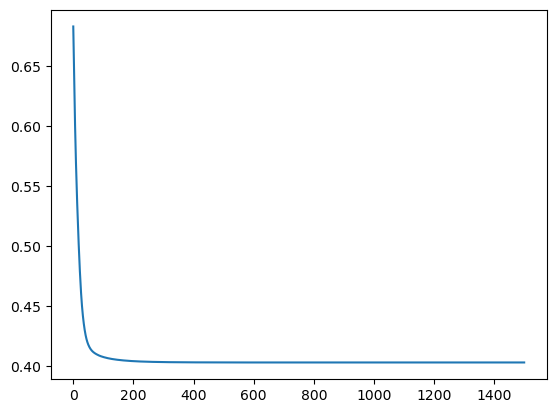

In [5]:

import torch.nn as nn

LEARNING_RATE = 0.001
EPOCHS = 1500

# Define the model
model = nn.Sequential(
    nn.Linear(x_train.shape[1], 128),
    nn.ReLU(),
    nn.Linear(128, 2),
    nn.Softmax(dim=1)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

losses = []

for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    y_pred = model(torch.tensor(x_train).float())
    loss = loss_fn(y_pred, torch.tensor(y_train).long())
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss {loss.item()}")
        
model.eval()
y_pred = model(torch.tensor(x_train).float())
y_pred = torch.argmax(y_pred, dim=1)

# Evaluate training accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy on training set is {accuracy}")

# Plot the loss
import matplotlib.pyplot as plt

plt.plot(losses)

In [6]:
# Evaluate the model

model.eval()
y_pred = model(torch.tensor(x_test).float())
y_pred = torch.argmax(y_pred, dim=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on testing set is {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

# confusion_matrix(y_test, y_pred)
# display = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=range(6))

# display.plot()


Accuracy on testing set is 0.9117597244961327
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      8976
           1       0.91      0.91      0.91      8737

    accuracy                           0.91     17713
   macro avg       0.91      0.91      0.91     17713
weighted avg       0.91      0.91      0.91     17713



In [7]:
# Save the weights

weights_str = ""
biases_str = ""

for param in model.named_parameters():
    isBias = False
    if "0.weight" in param[0]:
        weights_str += ("custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {")
        isBias = False
    if "0.bias" in param[0]:
        biases_str += ("custom_float input_bias[HIDDEN_LAYER_NODES] = {")
        isBias = True
    if "2.weight" in param[0]:
        weights_str += ("custom_float output_weight[HIDDEN_LAYER_NODES * OUTPUT_NODES] = {")
        isBias = False
    if "2.bias" in param[0]:
        biases_str += ("custom_float output_bias[OUTPUT_NODES] = {")
        isBias = True
        
    weight = param[1].detach().numpy().flatten().tolist()
    for w in weight:
        if isBias:
            biases_str += str(w) + ","
        else:
            weights_str += str(w) + ","
            
    if isBias:
        biases_str += "};\n\n"
    else:
        weights_str += "};\n\n"
        
print(weights_str)
print(biases_str)

custom_float input_weight[INPUT_NODES * HIDDEN_LAYER_NODES] = {-0.00479467399418354,0.013745815493166447,-0.012530791573226452,-0.00022011311375536025,0.0012958177831023932,-0.0034060487523674965,0.014074079692363739,0.04278206825256348,0.007247946225106716,-0.0012072263052687049,0.0004319871077314019,0.007077124435454607,0.00464050006121397,0.02826373279094696,-0.002641341183334589,-0.0007142883841879666,0.0008643497130833566,0.0018355202628299594,0.009434640407562256,0.014519265852868557,0.009889238514006138,-0.0004940242506563663,-0.0004315771802794188,0.005241597071290016,0.011686103418469429,-0.007074595429003239,0.01176560577005148,0.001822302583605051,0.004444959107786417,4.4376742152962834e-05,0.015641530975699425,0.0026451912708580494,0.012375010177493095,-0.0012503371108323336,0.0069860611110925674,0.005792803596705198,0.017684509977698326,-0.015444992110133171,0.01960056833922863,0.004088884685188532,0.006389570888131857,-0.00319645251147449,0.052503641694784164,-0.037384625

In [8]:
# Generate test cases for HLS

random.seed(SEED)

TEST_CASES = 100

test_cases = []

for i in range(TEST_CASES):
    test_case = random.choice(x_test)
    test_cases.append(test_case)

test_cases = np.array(test_cases)
single_test_case = test_cases[12]

raw_output = model(torch.tensor(test_cases).float()).detach().numpy()
pred_output = np.argmax(raw_output, axis=1)
single_pred_output = pred_output[12]

test_cases_str = "float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {"
pred_output_str = "int test_output[TEST_CASES_NUMBER] = {"

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ","
for output in pred_output:
    pred_output_str += str(output) + ","

test_cases_str += "};\n"
pred_output_str += "};\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

float test_case[TEST_CASES_NUMBER * INPUT_NODES] = {0.2738,-1.1612,-0.0147,-0.3215,-0.7627,-1.5634,0.3182,-0.7035,0.0188,0.2239,0.6269,2.1129,0.296,-0.93235,0.0020500000000000006,-0.04880000000000001,-0.06790000000000002,0.27474999999999994,0.022199999999999998,0.22885,0.01675,0.2727,0.6948000000000001,1.8381499999999997,0.29683133257794736,0.9600254397670929,0.01687498148147132,0.27703200176152937,0.6981099125495928,1.8585701452998753,0.044399999999999995,0.4577,0.004100000000000001,0.09760000000000002,0.13580000000000003,0.5494999999999999,0.592,1.8647,0.0335,0.5454,1.3896000000000002,3.6762999999999995,0.3524353599999999,3.68659538,0.0011390600000000001,0.30698692,1.9494298000000005,13.817131939999996,-3.3955,-0.2808,0.1461,-3.587,-1.217,-3.981,-0.4774,-0.0295,0.4093,1.2375,0.3322,-0.8324,-1.93645,-0.15515,0.2777,-1.17475,-0.4424,-2.4067,1.45905,0.12564999999999998,0.1316,2.4122500000000002,0.7746000000000001,1.5742999999999998,2.424595946750716,0.19964830327353147,0.307304165282542

In [9]:
# Generate single test case for pynq testing

TEST_CASES = 1

test_cases = []

for i in range(TEST_CASES):
    test_cases.append(single_test_case)

test_cases = np.array(test_cases)

pred_output = [ single_pred_output ]

test_cases_str = "test_input = ["
pred_output_str = "test_output = ["

for test_case in test_cases.flatten():
    test_cases_str += str(test_case) + ", "
for output in pred_output:
    pred_output_str += str(output) + ", "

test_cases_str += "]\n"
pred_output_str += "]\n"

# print the test cases and the predicted output
print(test_cases_str)
print(pred_output_str)

test_input = [-0.2702, 0.3476, -1.6994, -0.9882, -1.8759, -3.4155, 2.6841, 0.7465, -0.1028, 0.7897, -0.3428, -0.353, 1.20695, 0.54705, -0.9011, -0.09925, -1.10935, -1.8842500000000002, 1.47715, 0.19945000000000002, 0.7983, 0.8889499999999999, 0.76655, 1.5312500000000002, 1.9075377912376992, 0.5822748534841601, 1.203853853256283, 0.8944734009460538, 1.348427352511065, 2.427987772827532, 2.4139, 0.39890000000000003, 1.5966, 0.1985, 1.5331, 3.0625, 2.9543, 1.0941, 1.8022, 1.7778999999999998, 2.2187, 3.7685000000000004, 14.554801699999999, 1.3561760200000004, 5.797056400000001, 3.2003306599999997, 7.2730253000000005, 23.580498500000004, ]

test_output = [1, ]



In [10]:
import time

test_input = [[




        -0.479,




        -1.2179,




        -0.4232,




        -1.8137,




        -1.6443,




        -2.4633,




        -0.25,




        -0.6336,




        -0.0521,
        1.7223,
        1.2101,
        1.5145,




        -0.37152,




        -0.9549599999999998,




        -0.27877,
        0.01579999999999997,




        -0.06824000000000001,




        -0.12147999999999995,
        0.07483608487888714,
        0.17022435313432682,
        0.10513370582263332,
        1.2428805879890474,
        0.9801326330655459,
        1.323016568906074,
        0.3789822555212843,
        0.9700128514612577,
        0.2979359142500279,
        1.2429810119225475,
        0.9825053058380907,
        1.3285820381143199,
        0.15664944178238732,
        0.14990974565663218,
        0.08891696617581848,
        0.15799999999999992,
        0.6823999999999999,
        1.138002114427595,
        3.7152000000000003,
        9.5496,
        2.7877,
        8.085318979351786,
        6.2702644806469285,
        7.936206267958993,
        14.111870000000001,
        92.70797366,
        8.337194300000002,
        77.69912348,
        51.61267835999998,
        90.85490161999998
    ]]


start = time.time()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
output = model(torch.tensor(test_input).float()).detach().numpy()
end = time.time()

print("Time taken for 5 inferences is " + str((end - start)*1000) + " milliseconds")


print(output)

Time taken for 5 inferences is 1.1222362518310547 milliseconds
[[1.00000e+00 4.06421e-27]]
